# Recurrent Neural Networks in deep machine learning to predict patient mortality

In [67]:
import os
import numpy as np
import pandas as pd              
import matplotlib.pyplot as plt 
import random


In [2]:
# Configure the notebook to display plots
%matplotlib inline




In [4]:
# Define the path to the data folder
data_dir = '/dli/task/data/hx_series'

In [5]:
# training data inputs: x and targets: y
x_train_path = os.path.join(data_dir, 'X_train.hdf')
y_train_path = os.path.join(data_dir, 'y_train.hdf')

# validation data inputs: x and targest: y
x_valid_path = os.path.join(data_dir, 'X_test.hdf')
y_valid_path = os.path.join(data_dir, 'y_test.hdf')

In [6]:
# It should take less than one minute to load the files
X_train = pd.read_hdf(x_train_path)
y_train = pd.read_hdf(y_train_path)
X_valid = pd.read_hdf(x_valid_path)
y_valid = pd.read_hdf(y_valid_path)
print('data load complete')

data load complete


In [7]:
X_train

ABG Base excess (mEq/L)  ABG FiO2  ABG HCO3 (mEq/L)  \
encounterID absoluteTime                                                        
8           0.000000                          NaN       NaN               NaN   
            0.250000                          NaN       NaN               NaN   
            0.500000                          NaN       NaN               NaN   
            0.583333                          NaN       NaN               NaN   
            0.750000                          NaN       NaN               NaN   
...                                           ...       ...               ...   
16259       87.000000                         NaN       NaN               NaN   
            87.083336                         NaN       NaN               NaN   
            87.666664                         NaN       NaN               NaN   
            88.000000                         NaN       NaN               NaN   
            89.000000                         NaN       NaN               NaN   

                          ABG O2 sat (%)  ABG PCO2 (mmHg)  ABG PO2 (mmHg)  \
encounterID absoluteTime                                                    
8           0.000000                 NaN              NaN             NaN   
            0.250000                 NaN              NaN             NaN   
            0.500000                 NaN              NaN             NaN   
            0.583333                 NaN              NaN             NaN   
            0.750000                 NaN              NaN             NaN   
...                                  ...              ...             ...   
16259       87.000000                NaN              NaN             NaN   
            87.083336                NaN              NaN             NaN   
            87.666664                NaN              NaN             NaN   
            88.000000                NaN              NaN             NaN   
            89.000000                NaN              NaN             NaN   

                          ABG TCO2 (mEq/L)  ABG pH  ALT (SGPT) (units/L)  \
encounterID absoluteTime                                                   
8           0.000000                   NaN     NaN                   NaN   
            0.250000                   NaN     NaN                   NaN   
            0.500000                   NaN     NaN                   NaN   
            0.583333                   NaN     NaN                   NaN   
            0.750000                   NaN     NaN                   NaN   
...                                    ...     ...                   ...   
16259       87.000000                  NaN     NaN                   NaN   
            87.083336                  NaN     NaN                   NaN   
            87.666664                  NaN     NaN                   NaN   
            88.000000                  NaN     NaN                   NaN   
            89.000000                  NaN     NaN                   NaN   

                          AST (SGOT) (units/L)  ...  Vasopressin  Vecuronium  \
encounterID absoluteTime                        ...                            
8           0.000000                       NaN  ...          NaN         NaN   
            0.250000                       NaN  ...          NaN         NaN   
            0.500000                       NaN  ...          NaN         NaN   
            0.583333                       NaN  ...          NaN         NaN   
            0.750000                       NaN  ...          NaN         NaN   
...                                        ...  ...          ...         ...   
16259       87.000000                      NaN  ...          NaN         NaN   
            87.083336                      NaN  ...          NaN         NaN   
            87.666664                      NaN  ...          NaN         NaN   
            88.000000                      NaN  ...          NaN         NaN   
            89.000000

In [8]:
y_train

mortalityResponse
encounterID absoluteTime                   
8           0.000000                      1
            0.250000                      1
            0.500000                      1
            0.583333                      1
            0.750000                      1
...                                     ...
16259       87.000000                     1
            87.083336                     1
            87.666664                     1
            88.000000                     1
            89.000000                     1

[1113529 rows x 1 columns]

In [9]:
X_train.index.levels[0]

Int64Index([    8,    11,    13,    15,    18,    20,    21,    23,    25,
               27,
            ...
            16233, 16236, 16241, 16243, 16244, 16248, 16250, 16254, 16255,
            16259],
           dtype='int64', name='encounterID', length=5000)

In [10]:
# Select a random patient encounterID from a list of all the encounterID values
eIdx = random.choice(list(X_train.index.levels[0]))

# Specify a few variables to look at
variables = [
    'Age','Heart rate (bpm)','PulseOximetry','Weight',
    'SystolicBP','DiastolicBP','Respiratory rate (bpm)',
    'MotorResponse','Capillary refill rate (sec)'
]

# Note that the full list of variables can be constructed using
# list(X_train.columns.values)

# Have a look at the variables for the selected patient
print('encounterID = {}'.format(eIdx))
print('number of observations = {}'.format(X_train.loc[eIdx].index.shape[0]))
print('max absoluteTime value = {} hours'.format(X_train.loc[eIdx].index[-1]))
X_train.loc[eIdx, variables]

encounterID = 11600
number of observations = 222
max absoluteTime value = 111.66666412353516 hours


,Age,Heart rate (bpm),PulseOximetry,Weight,SystolicBP,DiastolicBP,Respiratory rate (bpm),MotorResponse,Capillary refill rate (sec)
absoluteTime,,,,,,,,,
0.000000,0.563309,NaN,NaN,8.69,NaN,NaN,21.0,NaN,NaN
0.083333,0.563319,109.0,100.0,NaN,NaN,NaN,20.0,NaN,NaN
0.166667,0.563328,95.0,100.0,8.70,132.0,74.0,20.0,NaN,4.0
0.200000,0.563332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.216667,0.563334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
108.666664,0.575706,131.0,100.0,NaN,103.0,58.0,37.0,6.0,2.0
109.666664,0.575820,118.0,100.0,NaN,98.0,64.0,41.0,NaN,NaN
110.666664,0.575934,127.0,97.0,NaN,NaN,NaN,40.0,6.0,2.0


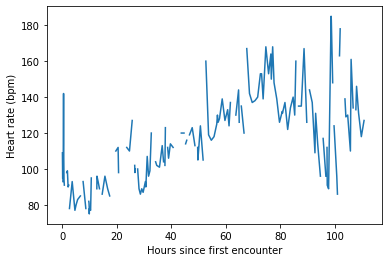

In [11]:
X_train.loc[eIdx, "Heart rate (bpm)"].plot()
plt.ylabel("Heart rate (bpm)")
plt.xlabel("Hours since first encounter")
plt.show()

In [12]:
# TODO Step 1 - Create a list of `encounterID` values
# Hint: In the single encounter example, we created this list and selected a random choice from it
eIdx_list = [] #FIXME
print('eIdx_list created of length {} (Sanity check: this length should be 5000)'.format(len(eIdx_list)))

eIdx_list created of length 0 (Sanity check: this length should be 5000)


In [13]:
# Step 2 - Create a list of observation counts for each of these encounters
# The number of observations in each encounter can be extracted as the shape of each individual encounter
nobs_list = [X_train.loc[ix].index.shape[0] for ix in eIdx_list]
print('list of observation counts created of length {} (Sanity check: this length should also be 5000)'.format(len(nobs_list)))

list of observation counts created of length 0 (Sanity check: this length should also be 5000)


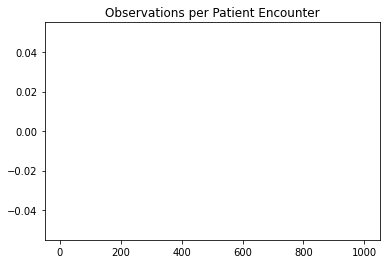

In [14]:
# Step 3 - Create a histogram using MatplotLib
plt.hist(nobs_list,range=(0,1000))
plt.title("Observations per Patient Encounter")
plt.show()

In [16]:
print('The mean = {}'.format(np.mean(nobs_list)))
print('The median = {}'.format(np.median(nobs_list)))

The mean = nan
The median = nan


In [17]:
# TODO Step 1 - Create a list of `encounterID` values
# Hint: Earlier in the section, we created this list and selected a random choice from it
eIdx_list = [] #FIXME
print('eIdx_list created of length {} (Sanity check: this length should be 5000)'.format(len(eIdx_list)))

eIdx_list created of length 0 (Sanity check: this length should be 5000)


In [ ]:
# TODO Step 2 - Create a list of `absoluteTime` final for each encounter
# Hint: Use a Python list comprehension over the eIdx_list
timespan_list = [] #FIXME
print('timespan_list created of length {} (Sanity check: this length should be 5000)'.format(len(timespan_list)))

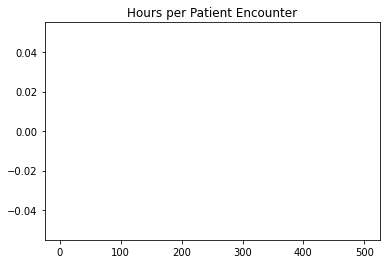

In [64]:
# Step 3 - Create a histogram using MatplotLib
plt.hist(timespan_list,range=(0,500))
plt.title("Hours per Patient Encounter")
plt.show()

In [65]:
print('The mean = {}'.format(np.mean(timespan_list)))
print('The median = {}'.format(np.median(timespan_list)))

The mean = nan
The median = nan


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [68]:
# Save the DataFrame's for use in other notebooks
X_train.to_pickle('X_train.pkl')
y_train.to_pickle('y_train.pkl')
X_valid.to_pickle('X_valid.pkl')
y_valid.to_pickle('y_valid.pkl')

AttributeError: 'numpy.ndarray' object has no attribute 'to_pickle'

In [ ]:
#2 Prepare the Data with pandas and NumPy

In [ ]:
import os
import numpy as np          
import pandas as pd              
import matplotlib.pyplot as plt  
import random
import tensorflow.keras as keras

# configure notebook to display plots
%matplotlib inline

# set up user paths
data_dir = '/dli/task/data/hx_series'
csv_dir = '/dli/task/csv'

In [24]:
# Fetch the DataFrame's loaded in the problem setup
X_train=pd.read_pickle('X_train.pkl')
y_train=pd.read_pickle('y_train.pkl')
X_valid=pd.read_pickle('X_valid.pkl')
y_valid=pd.read_pickle('y_valid.pkl')

In [25]:
#2.1 Normalize the Data

In [26]:
# Before normalization
X_train.loc[8,['Age','Heart rate (bpm)','PulseOximetry','Weight',
    'SystolicBP','DiastolicBP','Respiratory rate (bpm)',
    'MotorResponse','Capillary refill rate (sec)']]

,Age,Heart rate (bpm),PulseOximetry,Weight,SystolicBP,DiastolicBP,Respiratory rate (bpm),MotorResponse,Capillary refill rate (sec)
absoluteTime,,,,,,,,,
0.000000,7.573383,107.0,100.0,25.0,NaN,NaN,19.0,NaN,NaN
0.250000,7.573411,98.0,100.0,NaN,NaN,NaN,31.0,NaN,NaN
0.500000,7.573440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.583333,7.573450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.750000,7.573468,103.0,100.0,NaN,130.0,92.0,37.0,6.0,3.0
...,...,...,...,...,...,...,...,...,...
150.500000,7.590551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150.750000,7.590580,94.0,100.0,25.0,121.0,88.0,14.0,6.0,2.0
150.766663,7.590582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# create file path for csv file with metadata about variables
metadata = os.path.join(csv_dir, 'ehr_features.csv')

# read in variables from csv file (using pandas) since each varable there is tagged with a category
variables = pd.read_csv(metadata, index_col=0)

# next, select only variables of a particular category for normalization
normvars = variables[variables['type'].isin(['Interventions', 'Labs', 'Vitals'])]

# finally, iterate over each variable in both training and validation data
for vId, dat in normvars.iterrows():
    
    X_train[vId] = X_train[vId] - dat['mean']
    X_valid[vId] = X_valid[vId] - dat['mean']
    X_train[vId] = X_train[vId] / (dat['std'] + 1e-12)
    X_valid[vId] = X_valid[vId] / (dat['std'] + 1e-12)
    

In [28]:
# After normalization
X_train.loc[8,['Age','Heart rate (bpm)','PulseOximetry','Weight',
    'SystolicBP','DiastolicBP','Respiratory rate (bpm)',
    'MotorResponse','Capillary refill rate (sec)']]

,Age,Heart rate (bpm),PulseOximetry,Weight,SystolicBP,DiastolicBP,Respiratory rate (bpm),MotorResponse,Capillary refill rate (sec)
absoluteTime,,,,,,,,,
0.000000,7.573383,-0.429630,0.805317,-10.577633,NaN,NaN,-0.928604,NaN,NaN
0.250000,7.573411,-0.986894,0.805317,NaN,NaN,NaN,1.122353,NaN,NaN
0.500000,7.573440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.583333,7.573450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.750000,7.573468,-0.677303,0.805317,NaN,2.087398,3.242043,2.147832,1.240359,2.887591
...,...,...,...,...,...,...,...,...,...
150.500000,7.590551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150.750000,7.590580,-1.234567,0.805317,-10.577633,1.305183,2.874280,-1.783170,1.240359,-1.101130
150.766663,7.590582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
#2.2 Fill Data Gaps

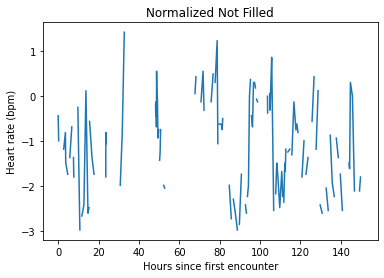

In [30]:
# Before filling gaps
X_train.loc[8, "Heart rate (bpm)"].plot()
plt.title("Normalized Not Filled")
plt.ylabel("Heart rate (bpm)")
plt.xlabel("Hours since first encounter")
plt.show()

In [31]:
# first select variables which will be filled in
fillvars = variables[variables['type'].isin(['Vitals', 'Labs'])].index

# next forward fill any missing values with more recently observed value
X_train[fillvars] = X_train.groupby(level=0)[fillvars].ffill()
X_valid[fillvars] = X_valid.groupby(level=0)[fillvars].ffill()

# finally, fill in any still missing values with 0 (i.e. values that could not be filled forward)
X_train.fillna(value=0, inplace=True)
X_valid.fillna(value=0, inplace=True)

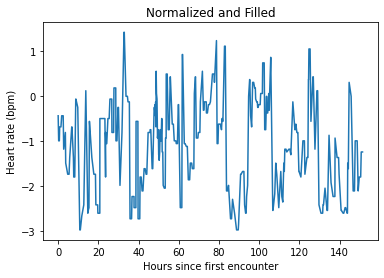

In [32]:
# After filling gaps
X_train.loc[8, "Heart rate (bpm)"].plot()
plt.title("Normalized and Filled")
plt.ylabel("Heart rate (bpm)")
plt.xlabel("Hours since first encounter")
plt.show()

In [33]:
X_train

ABG Base excess (mEq/L)  ABG FiO2  ABG HCO3 (mEq/L)  \
encounterID absoluteTime                                                        
8           0.000000                     0.000000  0.000000          0.000000   
            0.250000                     0.000000  0.000000          0.000000   
            0.500000                     0.000000  0.000000          0.000000   
            0.583333                     0.000000  0.000000          0.000000   
            0.750000                     0.000000  0.000000          0.000000   
...                                           ...       ...               ...   
16259       87.000000                    2.335037 -1.770313          2.569377   
            87.083336                    2.335037 -1.770313          2.569377   
            87.666664                    2.335037 -1.770313          2.569377   
            88.000000                    2.335037 -1.770313          2.569377   
            89.000000                    2.335037 -1.770313          2.569377   

                          ABG O2 sat (%)  ABG PCO2 (mmHg)  ABG PO2 (mmHg)  \
encounterID absoluteTime                                                    
8           0.000000            0.000000         0.000000          0.0000   
            0.250000            0.000000         0.000000          0.0000   
            0.500000            0.000000         0.000000          0.0000   
            0.583333            0.000000         0.000000          0.0000   
            0.750000            0.000000         0.000000          0.0000   
...                                  ...              ...             ...   
16259       87.000000          -2.668261         0.925765         -1.7796   
            87.083336          -2.668261         0.925765         -1.7796   
            87.666664          -2.668261         0.925765         -1.7796   
            88.000000          -2.668261         0.925765         -1.7796   
            89.000000          -2.668261         0.925765         -1.7796   

                          ABG TCO2 (mEq/L)    ABG pH  ALT (SGPT) (units/L)  \
encounterID absoluteTime                                                     
8           0.000000              0.000000  0.000000                   0.0   
            0.250000              0.000000  0.000000                   0.0   
            0.500000              0.000000  0.000000                   0.0   
            0.583333              0.000000  0.000000                   0.0   
            0.750000              0.000000  0.000000                   0.0   
...                                    ...       ...                   ...   
16259       87.000000             2.385686  0.845536                   0.0   
            87.083336             2.385686  0.845536                   0.0   
            87.666664             2.385686  0.845536                   0.0   
            88.000000             2.385686  0.845536                   0.0   
            89.000000             2.385686  0.845536                   0.0   

                          AST (SGOT) (units/L)  ...  Vasopressin  Vecuronium  \
encounterID absoluteTime                        ...                            
8           0.000000                       0.0  ...          0.0         0.0   
            0.250000                       0.0  ...          0.0         0.0   
            0.500000                       0.0  ...          0.0         0.0   
            0.583333                       0.0  ...          0.0         0.0   
            0.750000                       0.0  ...          0.0         0.0   
...                                        ...  ...          ...         ...   
16259       87.000000                      0.0  ...          0.0         0.0   
            87.083336                      0.0  ...          0.0         0.0   
            87.666664                      0.0  ...          0.0         0.0   
            88.000000                      0.0  ...          0.0         0.

In [34]:
type(X_train)

pandas.core.frame.DataFrame

In [35]:
#2.3 Pad Variable Length Sequences

In [36]:
from tensorflow.keras.preprocessing import sequence

# max number of sequence length
maxlen = 500

# get a list of unique patient encounter IDs
teId = X_train.index.levels[0]
veId = X_valid.index.levels[0]

# pad every patient sequence with 0s to be the same length, 
# then transforms the list of sequences to one numpy array
# this is for efficient minibatching and GPU computations 
X_train = [X_train.loc[patient].values for patient in teId]
y_train = [y_train.loc[patient].values for patient in teId]

X_train = sequence.pad_sequences(X_train, dtype='float32', maxlen=maxlen, padding='post', truncating='post')
y_train = sequence.pad_sequences(y_train, dtype='float32', maxlen=maxlen, padding='post', truncating='post')

# repeat for the validation data

X_valid = [X_valid.loc[patient].values for patient in veId]
y_valid = [y_valid.loc[patient].values for patient in veId]

X_valid = sequence.pad_sequences(X_valid, dtype='float32', maxlen=maxlen, padding='post', truncating='post')
y_valid = sequence.pad_sequences(y_valid, dtype='float32', maxlen=maxlen, padding='post', truncating='post')

In [37]:
# print the shape of the array which will be used by the network
# the shape is of the form (# of encounters, length of sequence, # of features)
print("X_train shape: %s | y_train shape: %s" % (str(X_train.shape), str(y_train.shape)))
print("X_valid shape: %s | y_valid shape: %s" % (str(X_valid.shape), str(y_valid.shape)))

X_train shape: (5000, 500, 265) | y_train shape: (5000, 500, 1)
X_valid shape: (2690, 500, 265) | y_valid shape: (2690, 500, 1)


In [38]:
type(X_train)

numpy.ndarray

ix = 3065


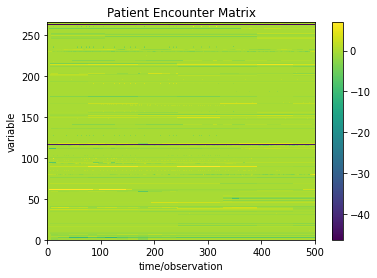

In [39]:
# figure out how many encounters we have
numencnt = X_train.shape[0]

# choose a random patient encounter to plot
ix = random.randint(0,5000) #Try a few different index values between 0 and 4999
print('ix = {}'.format(ix))

# plot a matrix of observation values
plt.title("Patient Encounter Matrix")
plt.pcolor(np.transpose(X_train[ix,:,:]))
plt.ylabel("variable")
plt.xlabel("time/observation")
plt.ylim(0,265)
plt.colorbar()
plt.show()

In [40]:
#2.3.1 Exercise: Padded Variable over all Patient Encounters

ERROR found: not enough values to unpack (expected 2, got 1)


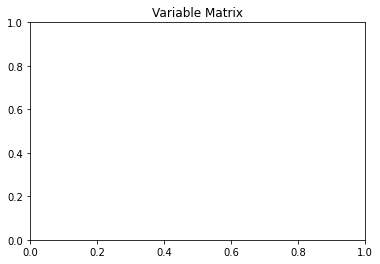

In [62]:
# TODO Step 1 set the variable value (feature number)
varnum = None  #FIXME

# TODO Step 2 Create a matrix of encounters vs time/observation
# Hint: Select along the 3rd axis
varmatrix = []  #FIXME

# Step 3 Plot the matrix
try:
    plt.title("Variable Matrix")
    plt.pcolor(varmatrix) 
    plt.ylabel("time/observation")
    plt.xlabel("encounter")
    plt.ylim(0,600)
    plt.colorbar()
    plt.show()
except Exception as e:
    print('ERROR found: {}'.format(e))

In [63]:
#2.4 Save a NumPy Arrays

In [43]:
# Save the prepared numpy arrays for use in other notebooks
np.save('X_train_prepared.npy',X_train,allow_pickle=False)
np.save('y_train_prepared.npy',y_train,allow_pickle=False)
np.save('X_valid_prepared.npy',X_valid,allow_pickle=False)
np.save('y_valid_prepared.npy',y_valid,allow_pickle=False)

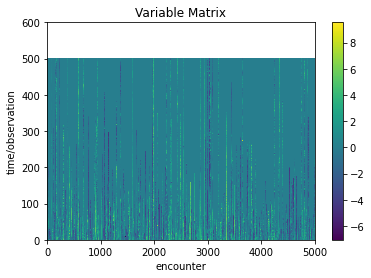

In [44]:
# TODO Step 1 set the variable value (feature number)
varnum = 115 #FIXME  (any number between 0 and 264, inclusive)

# TODO Step 2 Create a matrix of encounters vs time/observation
# Hint: Select along the 3rd axis
varmatrix = np.transpose(X_train[:,:,varnum])  #FIXME

# Step 3 Plot the matrix
try:
    plt.title("Variable Matrix")
    plt.pcolor(varmatrix) 
    plt.ylabel("time/observation")
    plt.xlabel("encounter")
    plt.ylim(0,600)
    plt.colorbar()
    plt.show()
except Exception as e:
    print('ERROR found: {}'.format(e))

In [45]:
#3. Build a Time Series Data Model with Keras

In [46]:
import os
import numpy as np          
import pandas as pd              
import matplotlib.pyplot as plt  
import random
import tensorflow.keras as keras

# configure notebook to display plots
%matplotlib inline

# set up user paths
data_dir = '/dli/task/data/hx_series'
csv_dir = '/dli/task/csv'

In [47]:
# Fetch the DataFrame's loaded in the problem setup
X_train=np.load('X_train_prepared.npy')
y_train=np.load('y_train_prepared.npy')
X_valid=np.load('X_valid_prepared.npy')
y_valid=np.load('y_valid_prepared.npy')

In [48]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Masking
from tensorflow.keras.optimizers import RMSprop

# construct inputs
x = Input((None, X_train.shape[-1]) , name='input')
mask = Masking(0, name='input_masked')(x)

# stack LSTMs
lstm_kwargs = {'dropout': 0.25, 'recurrent_dropout': 0.1, 'return_sequences': True, 'implementation': 2}
lstm1 = LSTM(128, name='lstm1', **lstm_kwargs)(mask)

# output: sigmoid layer
output = TimeDistributed(Dense(1, activation='sigmoid'), name='output')(lstm1)
model = Model(inputs=x, outputs=output)

# compile model
optimizer = RMSprop(lr=0.005)
model.compile(optimizer=optimizer, loss='binary_crossentropy')

# print layer shapes and model parameters
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None, 265)]       0         
_________________________________________________________________
input_masked (Masking)       (None, None, 265)         0         
_________________________________________________________________
lstm1 (LSTM)                 (None, None, 128)         201728    
_________________________________________________________________
output (TimeDistributed)     (None, None, 1)           129       
Total params: 201,857
Trainable params: 201,857
Non-trainable params: 0
_________________________________________________________________


In [49]:
#3.2 Train the Model

In [50]:
# this will take a while...
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1)

Train on 5000 samples
Epoch 1/5
5000/5000 [==============================] - 54s 11ms/sample - loss: 0.0839
Epoch 2/5
5000/5000 [==============================] - 51s 10ms/sample - loss: 0.0657
Epoch 3/5
5000/5000 [==============================] - 51s 10ms/sample - loss: 0.0628
Epoch 4/5
5000/5000 [==============================] - 51s 10ms/sample - loss: 0.0594
Epoch 5/5
5000/5000 [==============================] - 51s 10ms/sample - loss: 0.0579


In [51]:
#3.3 Evaluate the Model Using Validation Data

In [52]:
# Generate model results on the holdout validation set
preds = model.predict(X_valid)

In [53]:
preds.shape

(2690, 500, 1)

In [54]:
#3.4 Visualize the Results

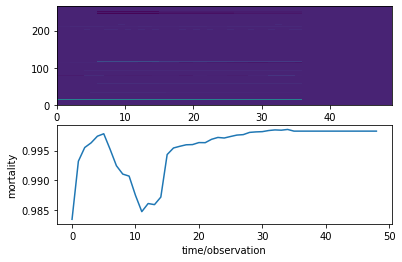

In [55]:
# Figure out how many encounters we have
numencnt = X_valid.shape[0]

# Choose a random patient encounter to plot
ix = random.randint(0,numencnt-1)

# Create axis side by side
f, (ax1, ax2) = plt.subplots(2, 1)

# Plot the observation chart for the random patient encounter
ax1.pcolor(np.transpose(X_valid[ix,1:50,:]))
ax1.set_ylim(0,265)
plt.ylabel("mortality")
plt.xlabel("time/observation")

# Plot the patient survivability prediction
ax2.plot(preds[ix,1:50]);

In [56]:
#3.5 Compare Against Baselines: PRISM3 and PIM2

In [57]:
from sklearn.metrics import roc_curve, auc

# get 0/1 binary label for each patient encounter
label = y_valid[:, 0, :].squeeze();

# get the last prediction in [0,1] for the patient
prediction = preds[:, -1, :].squeeze()

# compute ROC curve for predictions
rnn_roc = roc_curve(label,prediction)

# compute the area under the curve of prediction ROC
rnn_auc = auc(rnn_roc[0], rnn_roc[1])

In [58]:
# scores for baselines PRISM3 and PIM2 were aggregated and stored in `data/pim2prism3.csv`.
# load the scores and then compute the ROC curves and AUC
index = pd.read_csv(os.path.join('/dli/task/csv', 'pim2prism3.csv'))

# get the mortality reponse for each patient
mortrep = index['mortalityResponse'];

# generate ROC curves for each index
pim2_roc   = roc_curve(mortrep, -index['PIM2'  ])
prism3_roc = roc_curve(mortrep, -index['PRISM3'])

# compute the area under the curve for each index
pim2_auc   = auc(  pim2_roc[0],   pim2_roc[1])
prism3_auc = auc(prism3_roc[0], prism3_roc[1])

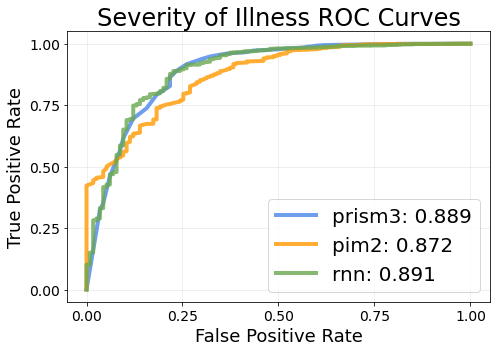

In [59]:
# plot rocs & display AUCs
plt.figure(figsize=(7, 5))
line_kwargs = {'linewidth': 4, 'alpha': 0.8}
plt.plot(prism3_roc[0], prism3_roc[1], label='prism3: %0.3f' % prism3_auc, color='#4A86E8', **line_kwargs)
plt.plot(pim2_roc[0], pim2_roc[1], label='pim2: %0.3f' % pim2_auc, color='#FF9900', **line_kwargs)
plt.plot(rnn_roc[0], rnn_roc[1], label='rnn: %0.3f' % rnn_auc, color='#6AA84F', **line_kwargs)
plt.legend(loc='lower right', fontsize=20)
plt.xlim((-0.05, 1.05))
plt.ylim((-0.05, 1.05))
plt.xticks([0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.yticks([0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.xlabel("False Positive Rate", fontsize=18)
plt.ylabel("True Positive Rate", fontsize=18)
plt.title("Severity of Illness ROC Curves", fontsize=24)
plt.grid(alpha=0.25)
plt.tight_layout()

In [60]:
#3.6 Conclusion

In [61]:
#RNNs provide a method to quickly extract clinically significant information and insights from available EHR data.

#The amount of data, model complexity, number of features, and number of epochs have been reduced in this tutorial to reduce computational burden. The examples below display the performance of a fully trained RNN on a larger dataset. They also show the performance of PIM2 and PRISM3, two standard scoring systems, as well as the performance of a logistic regression model and a multi-layer perceptron (MLP).

#The temporally dynamic nature of the RNN enables it to extract more information from the underlying EHR than an MLP. The MLP's complexity is similar to the RNN's, but the former is limited to instantaneous information.